In [52]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import time
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,classification_report
from sklearn.preprocessing import MinMaxScaler,StandardScaler
!pip install --upgrade category_encoders
from sklearn.model_selection import GridSearchCV
import category_encoders as ce
%matplotlib inline
import math
from scipy.spatial.distance import cdist

In [53]:
RANDOM_STATE = 42

## Загружаем данные

In [54]:
train_data = pd.read_csv('/content/train.csv')
X_test = pd.read_csv('/content/test.csv')

In [55]:
train_data.head()

,id,lat,lon,score
0,0,56.228300,43.945535,0.080523
1,1,56.834244,53.141543,0.104424
2,2,45.042299,41.990170,0.067615
3,3,59.849408,30.387762,0.088038
4,4,59.839643,30.304308,0.099686


## Рассмотрим распределение значений score

In [56]:
train_data.describe()

,id,lat,lon,score
count,3084.000000,3084.000000,3084.000000,3084.000000
mean,1541.500000,55.218066,43.942187,0.134855
std,890.418441,3.832649,12.074348,0.118598
min,0.000000,42.938677,20.472413,0.000000
25%,770.750000,54.706904,37.512346,0.077965
50%,1541.500000,55.788525,39.754105,0.095098
75%,2312.250000,56.886170,49.191428,0.118312
max,3083.000000,61.286672,132.024317,0.945558


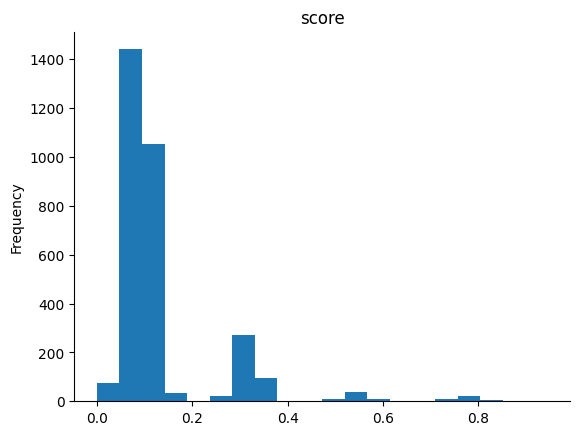

In [57]:
# @title score

from matplotlib import pyplot as plt
train_data['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [58]:
X_test.head()

,id,lat,lon
0,3084,55.782276,49.148234
1,3085,56.841500,35.853059
2,3086,55.356780,86.156697
3,3087,56.755087,60.703962
4,3088,59.907438,30.250297


## Проверим число признаков, наличие na в них

In [59]:
features = pd.read_csv('/content/features.csv')

In [60]:
features.head()

,lat,lon,0,1,2,3,4,5,6,7,...,353,354,355,356,357,358,359,360,361,362
0,59.837100,30.262701,0.411159,0.360032,0.350883,0.476389,0.373542,0.399907,0.397579,0.486442,...,0.041906,0.045916,0.085368,0.093044,0.014491,0.004091,0.043260,0.045916,0.060025,0.071592
1,59.935705,30.274201,0.500628,0.458489,0.522933,0.538892,0.482807,0.497257,0.541007,0.482956,...,0.041262,0.054171,0.066940,0.057510,0.007990,0.017897,0.042617,0.054171,0.047068,0.044251
2,59.929714,30.419863,0.450037,0.413593,0.445300,0.490658,0.403224,0.448099,0.516285,0.526028,...,0.044056,0.052290,0.126482,0.116896,0.006771,0.007329,0.045406,0.052290,0.088934,0.089945
3,56.111227,40.356119,0.160964,0.146153,0.301632,0.196871,0.157927,0.130723,0.246422,0.385300,...,0.043072,0.051181,0.042962,0.030555,0.010293,0.002216,0.044425,0.051181,0.030208,0.023510
4,56.233351,43.872728,0.102522,0.073835,0.270109,0.129343,0.106780,0.082463,0.201381,0.372377,...,0.047839,0.048137,0.135698,0.163684,0.009615,0.003579,0.049185,0.048137,0.095414,0.125946


In [61]:
features.isna()

,lat,lon,0,1,2,3,4,5,6,7,...,353,354,355,356,357,358,359,360,361,362
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
607,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
608,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
609,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Для представления мест features воспользуемся folium

In [62]:
!pip install folium

In [63]:
import folium

In [64]:
latitude_center, longitude_center = 50,80
mymap = folium.Map(location=[latitude_center, longitude_center], zoom_start=5)


for index, row in features.iterrows():
    folium.Marker(location=[row['lat'], row['lon']], popup="Point").add_to(mymap)




In [65]:
mymap

## Для добавления фичей к тестирующей выборке будем расматривать все фичи, находящиеся в определенной окружности около элемента выборки

In [66]:
y_train = train_data['score']
X_train = train_data.drop(columns=['score'])

In [67]:
from sklearn.neighbors import NearestNeighbors

In [68]:
from geopy.distance import geodesic

In [69]:
def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X)

    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()

In [70]:
k =  features.shape[-1]

#### Радиус в котором будем рассматривать ближайшие места с фичами, подберем также, как подбирается значение eps  в dbscan ![DBSCAN](https://www.khoury.northeastern.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/notes_slides/revisitofrevisitDBSCAN.pdf)


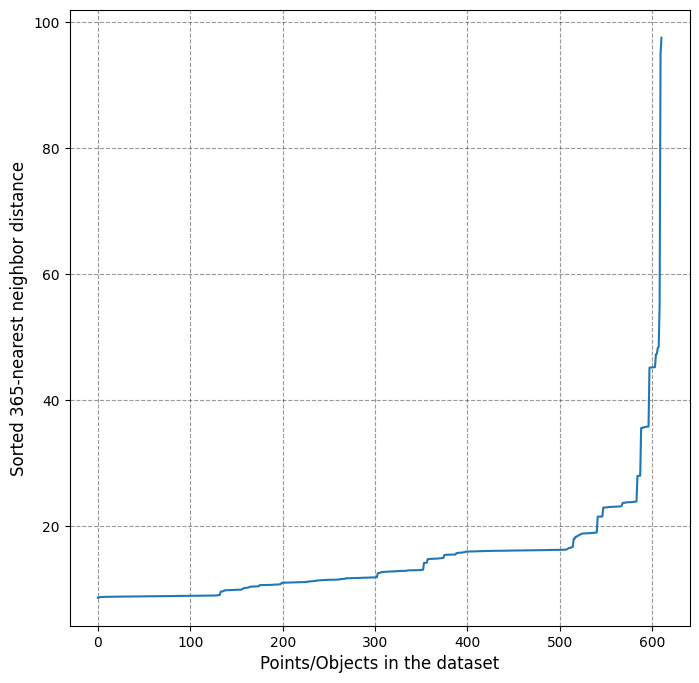

In [71]:
get_kdist_plot(X=features[['lat','lon']], k=k, radius_nbrs=10)

In [72]:
MAX_DIST = 10

 Заметим, что при расстоянии в ~30 единиц число рассматриваемых фичей сильно возрастает, после рассмотрения карты с follium, можно сделать вывод, что существует множество фичей, сгруппированных в одной точке, для уменьшения числа рассматриваемых мест и избежания шума возьмем радиус в 10 единиц, в таком случае будет рассмотрены ближайщие 10 километров и число рассматриваемых заведений в среднем будет около 200.

#### Для каждого места из train подберем все фичи в радиусе CLOSEST_DIST

Будем пренебрегать искривлениями земного шара(ввиду малых расстояний), будем просто считать расстояние межд 2 точками, в случае если точек рядом не оказалось, возьмем 1 наиближайшую.

In [73]:
def get_closest_features(given_loc, features, radius=MAX_DIST):
    distances = np.sqrt((features['lat'] - given_loc['lat'])**2 + (features['lon'] - given_loc['lon'])**2)
    within_radius_mask = distances <= radius
    closest_places = features[within_radius_mask]
    if len(closest_places) == 0:
      closest_place_ind = np.argmin(distances)
      return [features.iloc[closest_place_ind]],[distances[closest_place_ind]]
    return closest_places, distances[within_radius_mask]

### Преобразования датафрейма и получение векторного представления места

In [74]:
X_train['closest_features'] = X_train.apply(lambda pl: get_closest_features(pl,features,MAX_DIST), axis=1)

In [75]:
X_train.head()

,id,lat,lon,closest_features
0,0,56.228300,43.945535,"([lat, lon, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..."
1,1,56.834244,53.141543,"([lat, lon, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..."
2,2,45.042299,41.990170,"([lat, lon, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..."
3,3,59.849408,30.387762,"([lat, lon, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..."
4,4,59.839643,30.304308,"([lat, lon, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..."


 Умножим вектор фичей на вектор расстояний от рассматриваемого элемента выборки до каждой фичи, после чего усредним получемое значение (чем дальше место -- тем меньше значение фичи).

In [76]:
def calc_feature(features_and_dist):
  features = features_and_dist[0]
  distances = features_and_dist[1]
  features = np.array(features)
  distances = np.array(distances)
  features *= 1/distances[:, np.newaxis]
  real_feature = np.mean(features, axis=0)
  return real_feature


In [77]:
X_train['closest_features'] = X_train['closest_features'].apply(calc_feature)

Получим векторное представление элементов выборки в виде списка

In [78]:
X_train.head()

,id,lat,lon,closest_features
0,0,56.228300,43.945535,"[316.46466457660085, 241.48019221510347, 2.037..."
1,1,56.834244,53.141543,"[312.48551774366405, 292.63100777956316, 0.752..."
2,2,45.042299,41.990170,"[248.91702082138954, 201.83712503326333, 0.716..."
3,3,59.849408,30.387762,"[271.1798416728874, 181.98185883651834, 2.7973..."
4,4,59.839643,30.304308,"[273.1104616837149, 183.32890775525502, 2.8179..."


In [79]:
X_train.describe()

,id,lat,lon
count,3084.000000,3084.000000,3084.000000
mean,1541.500000,55.218066,43.942187
std,890.418441,3.832649,12.074348
min,0.000000,42.938677,20.472413
25%,770.750000,54.706904,37.512346
50%,1541.500000,55.788525,39.754105
75%,2312.250000,56.886170,49.191428
max,3083.000000,61.286672,132.024317


Преобразуем список в столбцы

In [80]:
train_df_result = pd.concat([X_train,X_train['closest_features'].apply(pd.Series).add_prefix('feature_')],axis=1)


In [81]:
train_df_result.head(5)

,id,lat,lon,closest_features,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_355,feature_356,feature_357,feature_358,feature_359,feature_360,feature_361,feature_362,feature_363,feature_364
0,0,56.228300,43.945535,"[316.46466457660085, 241.48019221510347, 2.037...",316.464665,241.480192,2.037461,1.894795,2.119013,2.287850,...,0.457370,0.482648,0.906544,0.896791,0.346446,0.238681,0.676752,0.704547,1.012858,1.083062
1,1,56.834244,53.141543,"[312.48551774366405, 292.63100777956316, 0.752...",312.485518,292.631008,0.752594,0.703312,1.451960,0.776284,...,0.436744,0.486770,0.960148,0.969798,0.394997,0.242162,0.698544,0.752000,1.083269,1.171246
2,2,45.042299,41.990170,"[248.91702082138954, 201.83712503326333, 0.716...",248.917021,201.837125,0.716459,0.717244,1.329623,0.738565,...,0.580826,0.645257,1.360417,1.311177,0.574064,0.378046,1.028417,1.086798,1.659386,1.740010
3,3,59.849408,30.387762,"[271.1798416728874, 181.98185883651834, 2.7973...",271.179842,181.981859,2.797388,2.525246,2.352674,3.224873,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,59.839643,30.304308,"[273.1104616837149, 183.32890775525502, 2.8179...",273.110462,183.328908,2.817916,2.543950,2.369409,3.248552,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Добавим таргет, для сохранения датафрейма

In [82]:
train_df_result = train_df_result.drop(columns =['closest_features'])

In [83]:
train_df_result['score'] = y_train

In [84]:
train_df_result.head(5)

,id,lat,lon,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_356,feature_357,feature_358,feature_359,feature_360,feature_361,feature_362,feature_363,feature_364,score
0,0,56.228300,43.945535,316.464665,241.480192,2.037461,1.894795,2.119013,2.287850,1.906635,...,0.482648,0.906544,0.896791,0.346446,0.238681,0.676752,0.704547,1.012858,1.083062,0.080523
1,1,56.834244,53.141543,312.485518,292.631008,0.752594,0.703312,1.451960,0.776284,0.713846,...,0.486770,0.960148,0.969798,0.394997,0.242162,0.698544,0.752000,1.083269,1.171246,0.104424
2,2,45.042299,41.990170,248.917021,201.837125,0.716459,0.717244,1.329623,0.738565,0.673689,...,0.645257,1.360417,1.311177,0.574064,0.378046,1.028417,1.086798,1.659386,1.740010,0.067615
3,3,59.849408,30.387762,271.179842,181.981859,2.797388,2.525246,2.352674,3.224873,2.619728,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.088038
4,4,59.839643,30.304308,273.110462,183.328908,2.817916,2.543950,2.369409,3.248552,2.638882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.099686


In [85]:
train_df_result.to_csv('train_features.csv')

## Работа с test

### Работа с test Аналогична работе с train:


1.   Получение фичей в радиусе, полученном на train
2.   Получение одной фичи с учетом расстояний от элемента выборки до них



In [86]:
X_test['closest_features'] = X_test.apply(lambda pl: get_closest_features(pl,features,MAX_DIST), axis=1)

In [87]:
X_test.head()

,id,lat,lon,closest_features
0,3084,55.782276,49.148234,"([lat, lon, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..."
1,3085,56.841500,35.853059,"([lat, lon, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..."
2,3086,55.356780,86.156697,"([lat, lon, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0...."
3,3087,56.755087,60.703962,"([lat, lon, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..."
4,3088,59.907438,30.250297,"([lat, lon, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ..."


In [88]:
X_test['closest_features'] = X_test['closest_features'].apply(calc_feature)

In [89]:
test_df_result = pd.concat([X_test,X_test['closest_features'].apply(pd.Series).add_prefix('feature_')],axis=1)

In [90]:
test_df_result.head()

,id,lat,lon,closest_features,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,...,feature_355,feature_356,feature_357,feature_358,feature_359,feature_360,feature_361,feature_362,feature_363,feature_364
0,3084,55.782276,49.148234,"[271.3241319714035, 227.3069667675935, 0.67691...",271.324132,227.306967,0.676911,0.680279,1.258390,0.678831,...,0.527981,0.574324,1.133653,1.117717,0.512714,0.318159,0.886179,0.920703,1.369289,1.468956
1,3085,56.841500,35.853059,"[260.1571628984155, 162.21220714520777, 1.6511...",260.157163,162.212207,1.651105,1.439293,1.719610,1.871026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3086,55.356780,86.156697,"[152.7612037642957, 234.8949033700055, 0.54378...",152.761204,234.894903,0.543788,0.543959,0.840763,0.541232,...,0.351022,0.367505,0.724478,0.688165,0.470524,0.246204,0.528778,0.536873,0.751124,0.809530
3,3087,56.755087,60.703962,"[203.31072471567674, 203.16294044374266, 0.468...",203.310725,203.162940,0.468552,0.436242,0.894044,0.477314,...,0.457705,0.475853,0.792306,0.797636,0.457422,0.262812,0.659849,0.684190,0.977570,1.077094
4,3088,59.907438,30.250297,"[275.3419391923365, 184.88508287239478, 2.8420...",275.341939,184.885083,2.842069,2.565769,2.389392,3.276520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
test_df_result = test_df_result.drop(columns =['closest_features'])

In [92]:
test_df_result.head()

,id,lat,lon,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_355,feature_356,feature_357,feature_358,feature_359,feature_360,feature_361,feature_362,feature_363,feature_364
0,3084,55.782276,49.148234,271.324132,227.306967,0.676911,0.680279,1.258390,0.678831,0.638667,...,0.527981,0.574324,1.133653,1.117717,0.512714,0.318159,0.886179,0.920703,1.369289,1.468956
1,3085,56.841500,35.853059,260.157163,162.212207,1.651105,1.439293,1.719610,1.871026,1.568013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3086,55.356780,86.156697,152.761204,234.894903,0.543788,0.543959,0.840763,0.541232,0.488315,...,0.351022,0.367505,0.724478,0.688165,0.470524,0.246204,0.528778,0.536873,0.751124,0.809530
3,3087,56.755087,60.703962,203.310725,203.162940,0.468552,0.436242,0.894044,0.477314,0.456971,...,0.457705,0.475853,0.792306,0.797636,0.457422,0.262812,0.659849,0.684190,0.977570,1.077094
4,3088,59.907438,30.250297,275.341939,184.885083,2.842069,2.565769,2.389392,3.276520,2.661471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
test_df_result.to_csv('test_features.csv')